##### Feature Selection Synthesis
We all have seen datasets. Sometimes they are small, but often at times, they are tremendously large in size. It becomes very challenging to process the datasets which are very large, at least significant enough to cause a processing bottleneck.

ften, in a high dimensional dataset, there remain some entirely irrelevant, insignificant and unimportant features. It has been seen that the contribution of these types of features is often less towards predictive modeling as compared to the critical features. They may have zero contribution as well. These features cause a number of problems which in turn prevents the process of efficient predictive modeling :
- Unnecessary resource allocation for these features.
- These features act as a noise for which the machine learning model can perform terribly poorly.
- The machine model takes more time to get trained.

The solution is Feature Selection which is the process of selecting out the most significant features from a given dataset. In many of the cases, Feature Selection can enhance the performance of a machine learning model as well.


We will work in this document on selecting k-features from a dataset with n-features using different methodes and see how does accuracy and time variate accordingly. 

A the end of the notebook, we will get two plots summarizing the results as follow : 
-  k-features selected accuracy plot per methode
-  k-features selected training time plot per methode 

it is both tested for house-votes-84 and iris dataset

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
from time import time

In [27]:
from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
data = pd.DataFrame(data= np.c_[iris['target'], iris['data']])

"""
data = pd.read_csv("datasets/house-votes-84.data", header = None)

inull = []

for i in range(data.shape[1]) :
    temp = data.index[data[i] == '?'].tolist()
    inull = list(set(inull) | set(temp))
print("taille : {0} \nnombre de features : {1} \nvaleur à null : {2}".format(data.shape[0],data.shape[1],len(inull)))

print(data.shape)
data.drop(data.index[inull], inplace=True)
print(data.shape)



data.replace(('republican', 'democrat'), (1, 0), inplace=True)
data.replace(('y', 'n'), (1, 0), inplace=True)


X = data.iloc[:,1:].values  #independent columns
y = data.iloc[:,0].values    #target column i.e price range
print(X.shape)
print(y.shape)
"""

#data = pd.read_csv("datasets/train.csv")

#X = data.iloc[:,:-1]  #independent columns
#y = data.iloc[:,-1]    #target column i.e price range

'\ndata = pd.read_csv("datasets/house-votes-84.data", header = None)\n\ninull = []\n\nfor i in range(data.shape[1]) :\n    temp = data.index[data[i] == \'?\'].tolist()\n    inull = list(set(inull) | set(temp))\nprint("taille : {0} \nnombre de features : {1} \nvaleur \xc3\xa0 null : {2}".format(data.shape[0],data.shape[1],len(inull)))\n\nprint(data.shape)\ndata.drop(data.index[inull], inplace=True)\nprint(data.shape)\n\n\n\ndata.replace((\'republican\', \'democrat\'), (1, 0), inplace=True)\ndata.replace((\'y\', \'n\'), (1, 0), inplace=True)\n\n\nX = data.iloc[:,1:].values  #independent columns\ny = data.iloc[:,0].values    #target column i.e price range\nprint(X.shape)\nprint(y.shape)\n'

##### No feature selection
we start by a regression using all dataset features

In [28]:
#Regression before feature selection

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split

X, x_test, y, y_test = train_test_split(X, y, test_size=0.35, random_state=0)

model = LogisticRegression()

start = time()
model.fit(X, y)
end = time()

predicted_classes = model.predict(x_test)

accuracy = accuracy_score(y_test,predicted_classes)

selected_features = range(1,X.shape[1])
# Create the synthesis DataFrame 
synthesis = pd.DataFrame([], columns = ['acc-' + str(i) + '-selected' for i in range(1,X.shape[1] +1)]) 
synthesis.loc['None',synthesis.columns[-1]] =  accuracy
times = pd.DataFrame([], columns = ['time--' + str(i) for i in range(1,X.shape[1] +1)])
times.loc['None',times.columns[-1]] = end - start
print(synthesis)

     acc-1-selected acc-2-selected acc-3-selected acc-4-selected
None            NaN            NaN            NaN       0.886792


##### chi2 independence test
apply SelectKBest class to extract top 10 best features using chi2 as score function
A small value will mean the feature `(Observed variable)` is independent of 𝑦 `(Expected variable)`. 
A large value will mean the feature is non-randomly related to 𝑦
![](chi2.webp)

To do this we use the SelectKBest provided by scikit-learn library, all we have to do is to specify `score_func` param as `chi2` and select `k` best features

In [29]:
acc = []
t = []
for k in selected_features :
    bestfeatures = SelectKBest(score_func=chi2, k=k)
    fit = bestfeatures.fit(X,y)
    
    #dfscores = pd.DataFrame(fit.scores_)
    #dfcolumns = pd.DataFrame(data.columns[1:])

    #concat two dataframes for better visualization 
    #featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    #featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(k,'Score'))  #print 'k' best features

    X_r = bestfeatures.transform(X) #reduce X to the selected 

    model = LogisticRegression()

    start = time()
    model.fit(X_r, y)
    end = time()
    t.append(end - start)
    predicted_classes = model.predict(bestfeatures.transform(x_test))

    accuracy = accuracy_score(y_test,predicted_classes)

    acc.append(accuracy)

synthesis.loc["chi2",0:-1] = acc
times.loc["chi2",0:-1] = t
print(synthesis)

     acc-1-selected acc-2-selected acc-3-selected acc-4-selected
None            NaN            NaN            NaN       0.886792
chi2       0.641509       0.716981       0.849057            NaN


##### Mutual information
Mutual information (MI) between two random variables is a non-negative value, which 
measures the dependency between the variables. It is equal to zero if and only if two 
random variables are independent, and higher values mean higher dependency.
![](mutual_info.svg)

To do this we use the SelectKBest provided by scikit-learn library, all we have to do is to specify `score_func` param as `mutual_info_classif` and select `k` best features

In [30]:
acc = []
t = []
for k in selected_features :
    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=k)
    fit = bestfeatures.fit(X,y)
    
    #dfscores = pd.DataFrame(fit.scores_)
    #dfcolumns = pd.DataFrame(X.columns)

    #concat two dataframes for better visualization 
    #featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    #featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(k,'Score'))  #print "k" best features
    X_r = bestfeatures.transform(X) #reduce X to the selected 

    model = LogisticRegression()

    start = time()
    model.fit(X_r, y)
    end = time()
    t.append(end - start)

    predicted_classes = model.predict(bestfeatures.transform(x_test))

    accuracy = accuracy_score(y_test,predicted_classes)

    acc.append(accuracy)

synthesis.loc["mi",0:-1] = acc
times.loc["mi",0:-1] = t
print(synthesis)

     acc-1-selected acc-2-selected acc-3-selected acc-4-selected
None            NaN            NaN            NaN       0.886792
chi2       0.641509       0.716981       0.849057            NaN
mi         0.679245       0.716981       0.849057            NaN


##### Correlations

this is a Filter Method in which  we get correlations of each features in dataset, then we select features highly correlated with the targeted data

![](corre.webp)

To do this we use the seaborn class to generate the `heatmap` and the select `k` best features

                   acc-1-selected acc-2-selected acc-3-selected acc-4-selected
None                          NaN            NaN            NaN       0.886792
chi2                     0.641509       0.716981       0.849057            NaN
mi                       0.679245       0.716981       0.849057            NaN
corr                     0.679245       0.716981       0.849057            NaN
p-value                  0.679245       0.716981       0.849057            NaN
gini_importance          0.679245       0.716981       0.849057            NaN
entropy_importance       0.679245       0.716981       0.849057            NaN
rfe                      0.679245       0.773585       0.849057            NaN
regularization                NaN            NaN            NaN       0.830189


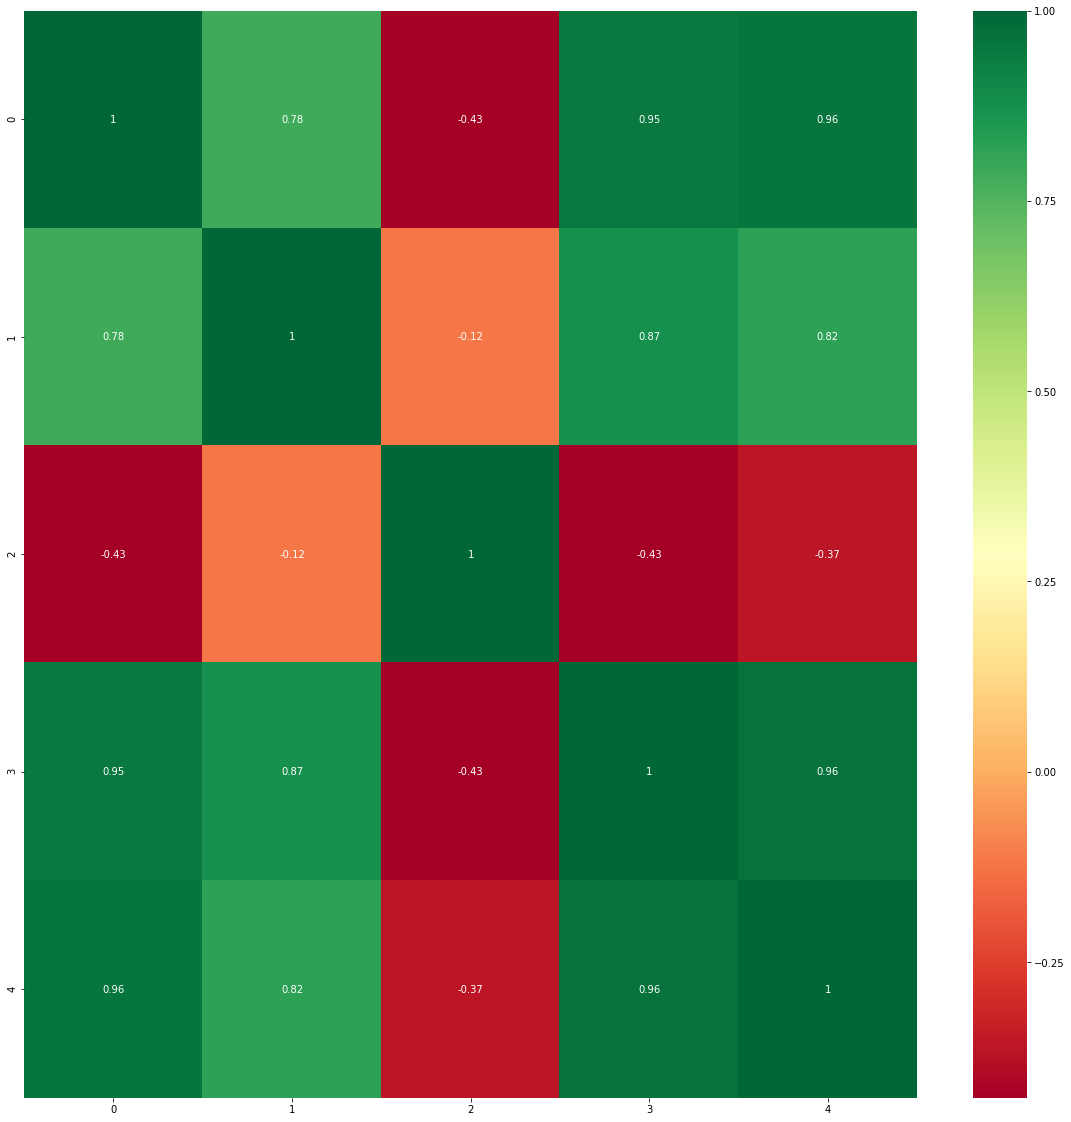

In [38]:
import seaborn as sns

corrmat = data.corr()

plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True,cmap="RdYlGn")
acc = []
t = []
for k in selected_features :
    sf = corrmat.loc[1:,0].nlargest(k).index - 1
    X_r = X[: , sf] #reduce X to the selected  

    model = LogisticRegression()

    start = time()
    model.fit(X_r, y)
    end = time()
    t.append(end - start)

    predicted_classes = model.predict(x_test[:,sf])

    accuracy = accuracy_score(y_test,predicted_classes)

    acc.append(accuracy)

synthesis.loc["corr",0:-1] = acc
times.loc["corr",0:-1] = t

print(synthesis)

##### p-value based test

Compute the ANOVA F-value for the provided sample : 
    F value = variance of the group means (Mean Square Between) / mean of the within group
    variances (Mean Squared Error)
Then we get the p-value (it shows the significance of correlation level).

To do this we use the SelectKBest provided by scikit-learn library, all we have to do is to specify `score_func` param as `f_classif` and select `k` best features

In [32]:
from sklearn.feature_selection import f_classif
acc = []
t = []
for k in selected_features :
    bestfeatures = SelectKBest(score_func= f_classif, k=k)
    fit = bestfeatures.fit(X,y)
    
    #dfscores = pd.DataFrame(fit.scores_)
    #dfcolumns = pd.DataFrame(X.columns)

    #concat two dataframes for better visualization 
    #featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    #featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(k,'Score'))  #print "k" best features
    X_r = bestfeatures.transform(X) #reduce X to the selected 

    model = LogisticRegression()

    start = time()
    model.fit(X_r, y)
    end = time()
    t.append(end - start)

    predicted_classes = model.predict(bestfeatures.transform(x_test))

    accuracy = accuracy_score(y_test,predicted_classes)

    acc.append(accuracy)

synthesis.loc["p-value",0:-1] = acc
times.loc["p-value",0:-1] = t

print(synthesis)

#### Feature importance

feature importance of each feature of the dataset by using the feature importance property of the model. Inbuilt class of 'Tree Based Classifiers' can be used to compute feature importances, which in turn can be used to discard irrelevant features 

To do this we exloit the importance function used in trees classifiers provided by scikit-learn library, the trick is to get values reterned by those classifiers and to use them in selecting `k` best features

In [33]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
acc = []
acc_ = []
t = []
t_ = []
for k in selected_features :
    model = ExtraTreesClassifier(criterion='gini')
    model_ = ExtraTreesClassifier(criterion='entropy')
    
    #print(model.feature_importances_) 
    #print(model_.feature_importances_)

    #plot graph of feature importances for better visualization
    #feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    #feat_importances.nlargest(10).plot(kind='barh')
    #plt.title = "gini"
    #plt.show()
    #feat_importances_ = pd.Series(model_.feature_importances_, index=X.columns)
    #feat_importances_.nlargest(10).plot(kind='barh')
    #plt.title = "entropy"
    #plt.show()

    #reduce data
    fit = SelectFromModel(model, threshold=-np.inf, max_features=k)
    start = time()
    fit.fit(X, y)
    end = time()
    t.append(end - start)
    X_r = fit.transform(X)
    fit_ = SelectFromModel(model_, threshold=-np.inf, max_features=k)
    start = time()
    fit_.fit(X, y)
    end = time()
    t_.append(end - start)
    X_r_ = fit_.transform(X)
    
    model = LogisticRegression()
    model_ = LogisticRegression()
    model.fit(X_r, y)
    model_.fit(X_r_, y)
    predicted_classes = model.predict(fit.transform(x_test))
    predicted_classes_ = model_.predict(fit_.transform(x_test))
    accuracy = accuracy_score(y_test,predicted_classes)
    acc.append(accuracy)

    accuracy = accuracy_score(y_test,predicted_classes_)
    acc_.append(accuracy)


synthesis.loc["gini_importance",0:-1] = acc
synthesis.loc["entropy_importance",0:-1] = acc_
times.loc["gini_importance",0:-1] = t
times.loc["entropy_importance",0:-1] = t_
print(synthesis)

#### Recursive feature elimination 

It is considered as a Wrapper Method. It works by selecting features by recursively considering smaller and smaller sets of features. First, the choosen model is trained on the initial set of features and the importance of each feature is obtained, then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

We will use RFE with the Logistic Regression classifier to select the top `k` features

In [34]:

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
acc = []
t = []
for k in selected_features :
    # create a base classifier used to evaluate a subset of attributes
    model = LogisticRegression()

    # create the RFE model and select 3 attributes
    rfe = RFE(model, k)
    start = time()
    rfe = rfe.fit(X, y)
    end = time()
    t.append(end - start)
    X_r = rfe.transform(X)
    # summarize the selection of the attributes
    #print(rfe.support_)
    #print(rfe.ranking_)
    model.fit(X_r, y)
    predicted_classes = model.predict(rfe.transform(x_test))
    accuracy = accuracy_score(y_test,predicted_classes)
    acc.append(accuracy)

synthesis.loc["rfe",0:-1] = acc
times.loc["rfe",0:-1] = t


print(synthesis)

#### Removing features with low variance

this is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold, i.e. features that have a very similar the same value in all samples.

In [35]:
#remove all the zero-variance features
print(data.loc[:,1:].std())
X_r = data.loc[:,1:][data.loc[:,1:].columns[data.loc[:,1:].std()>= (0.8*(1-0.8))]]

1    0.828066
2    0.435866
3    1.765298
4    0.762238
dtype: float64


#### L1 Regularization

Linear models (in particular : Lasso Regression) penalized with the L1 norm, estimated coefficients are zero for non significant features . This can be used to reduce the dimensionality of the data to use with a classifier by select the non-zero coefficients. 


In [36]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False)
sel = SelectFromModel(lsvc)
#print(dfcolumns[sel.get_support()])
sel.fit(X, y)
X_r = sel.transform(X) #reduce X to the selected 

model = LogisticRegression()

start = time()
model.fit(X_r, y)
end = time()

predicted_classes = model.predict(sel.transform(x_test))

accuracy = accuracy_score(y_test,predicted_classes)

synthesis.loc["regularization",synthesis.columns[X_r.shape[1]]] = accuracy
times.loc["regularization",times.columns[X_r.shape[1]]] = end - start


print(synthesis)

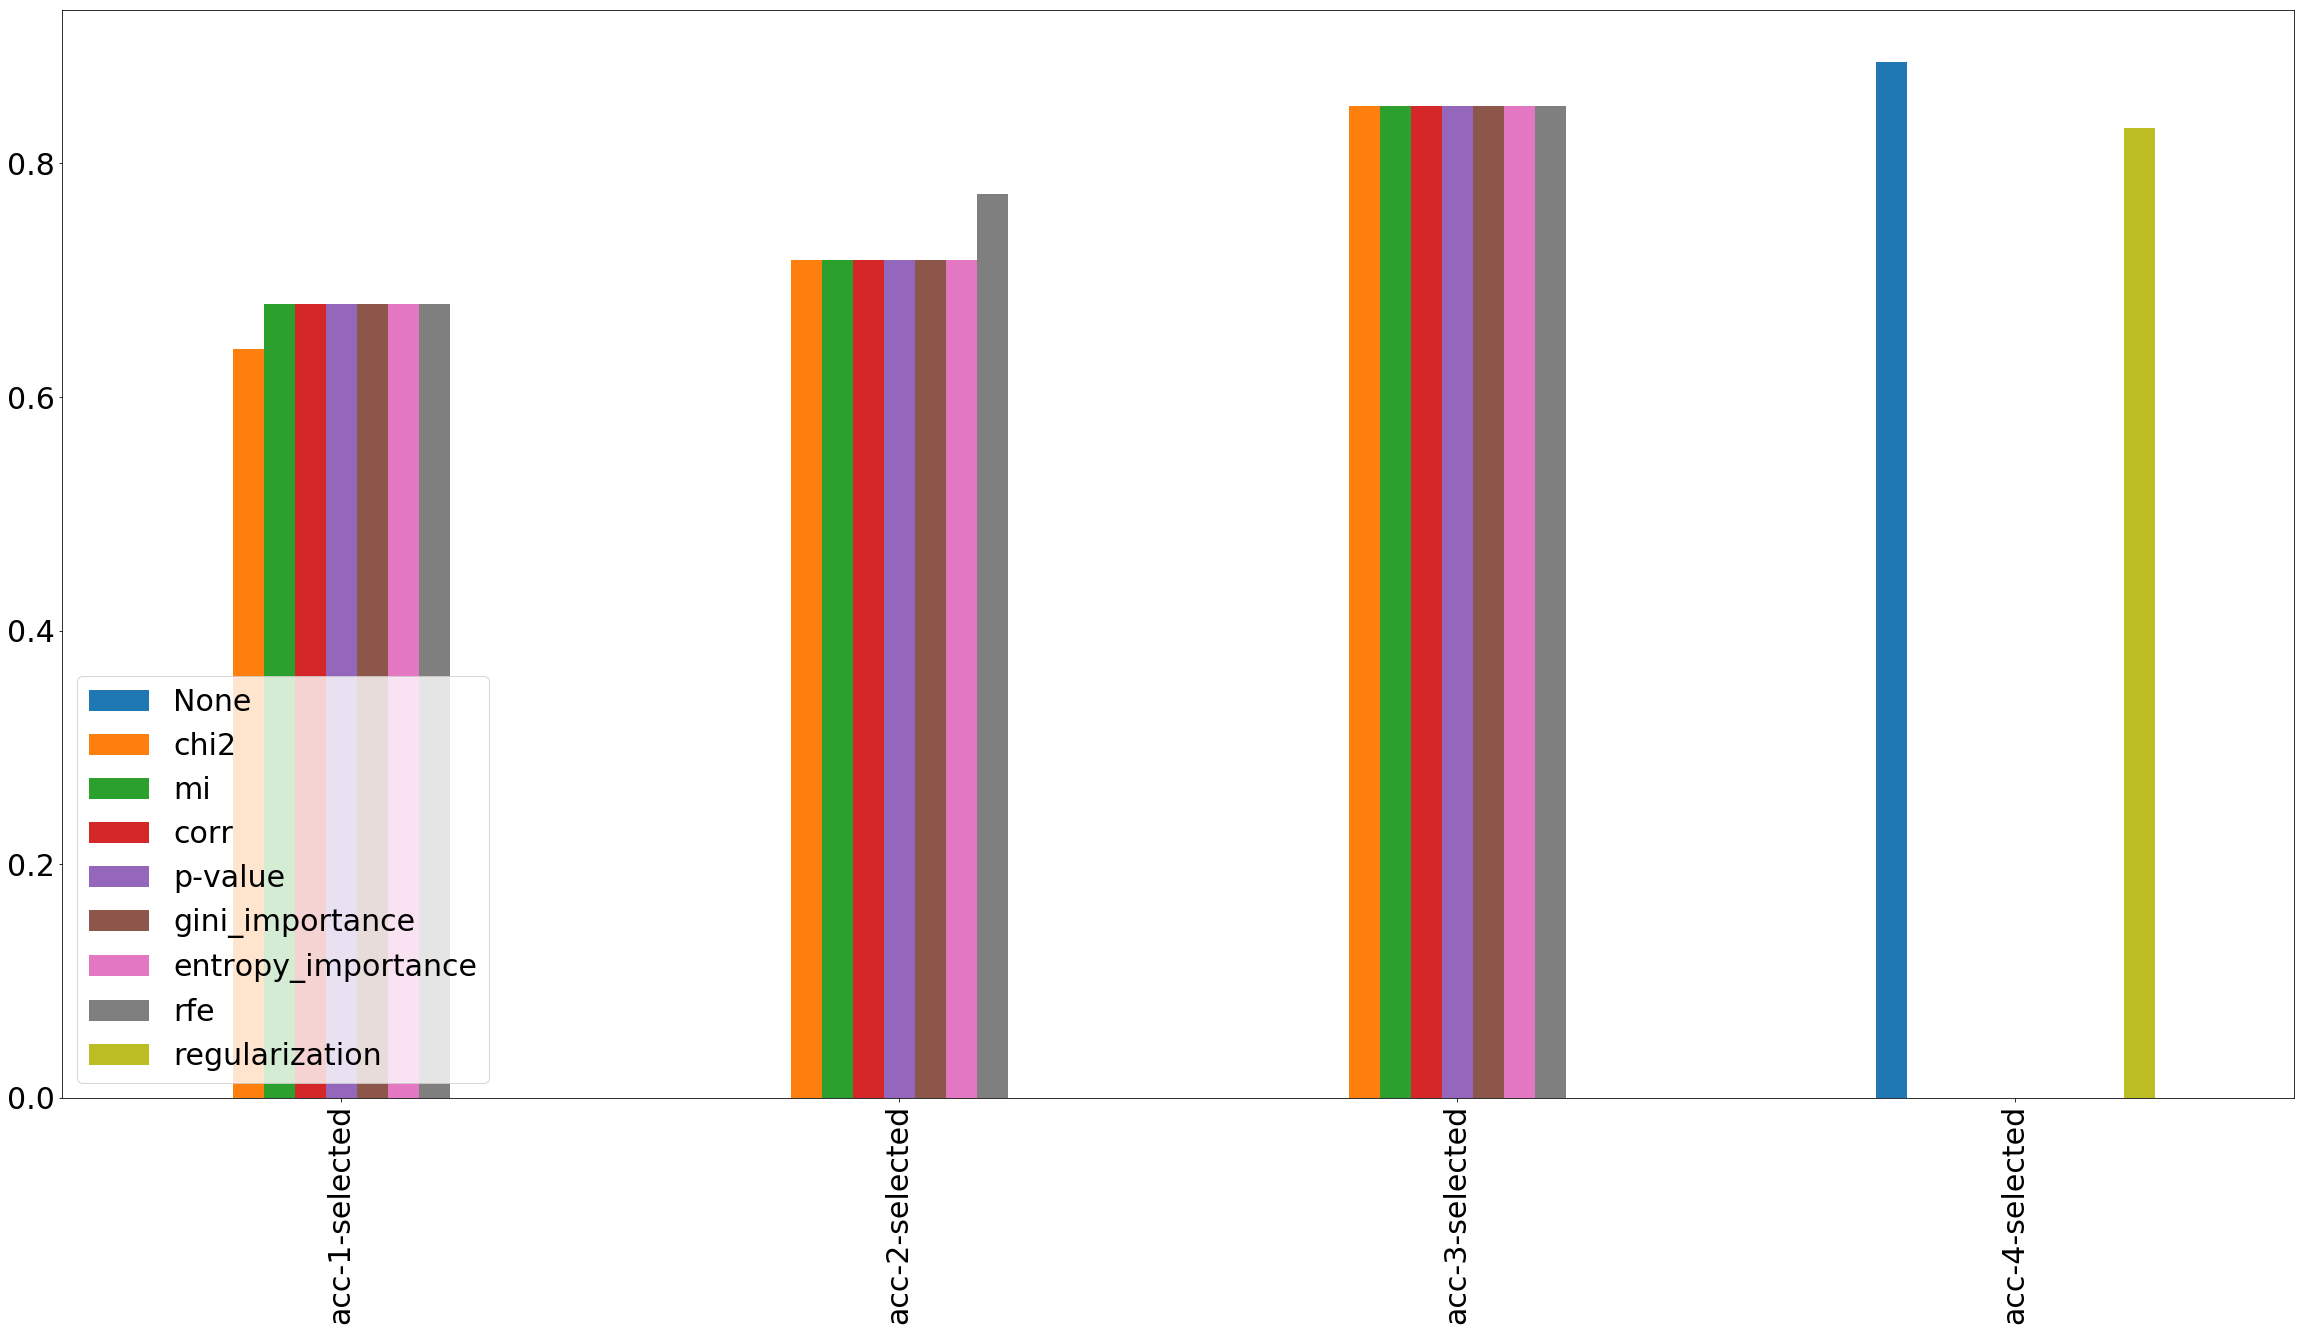

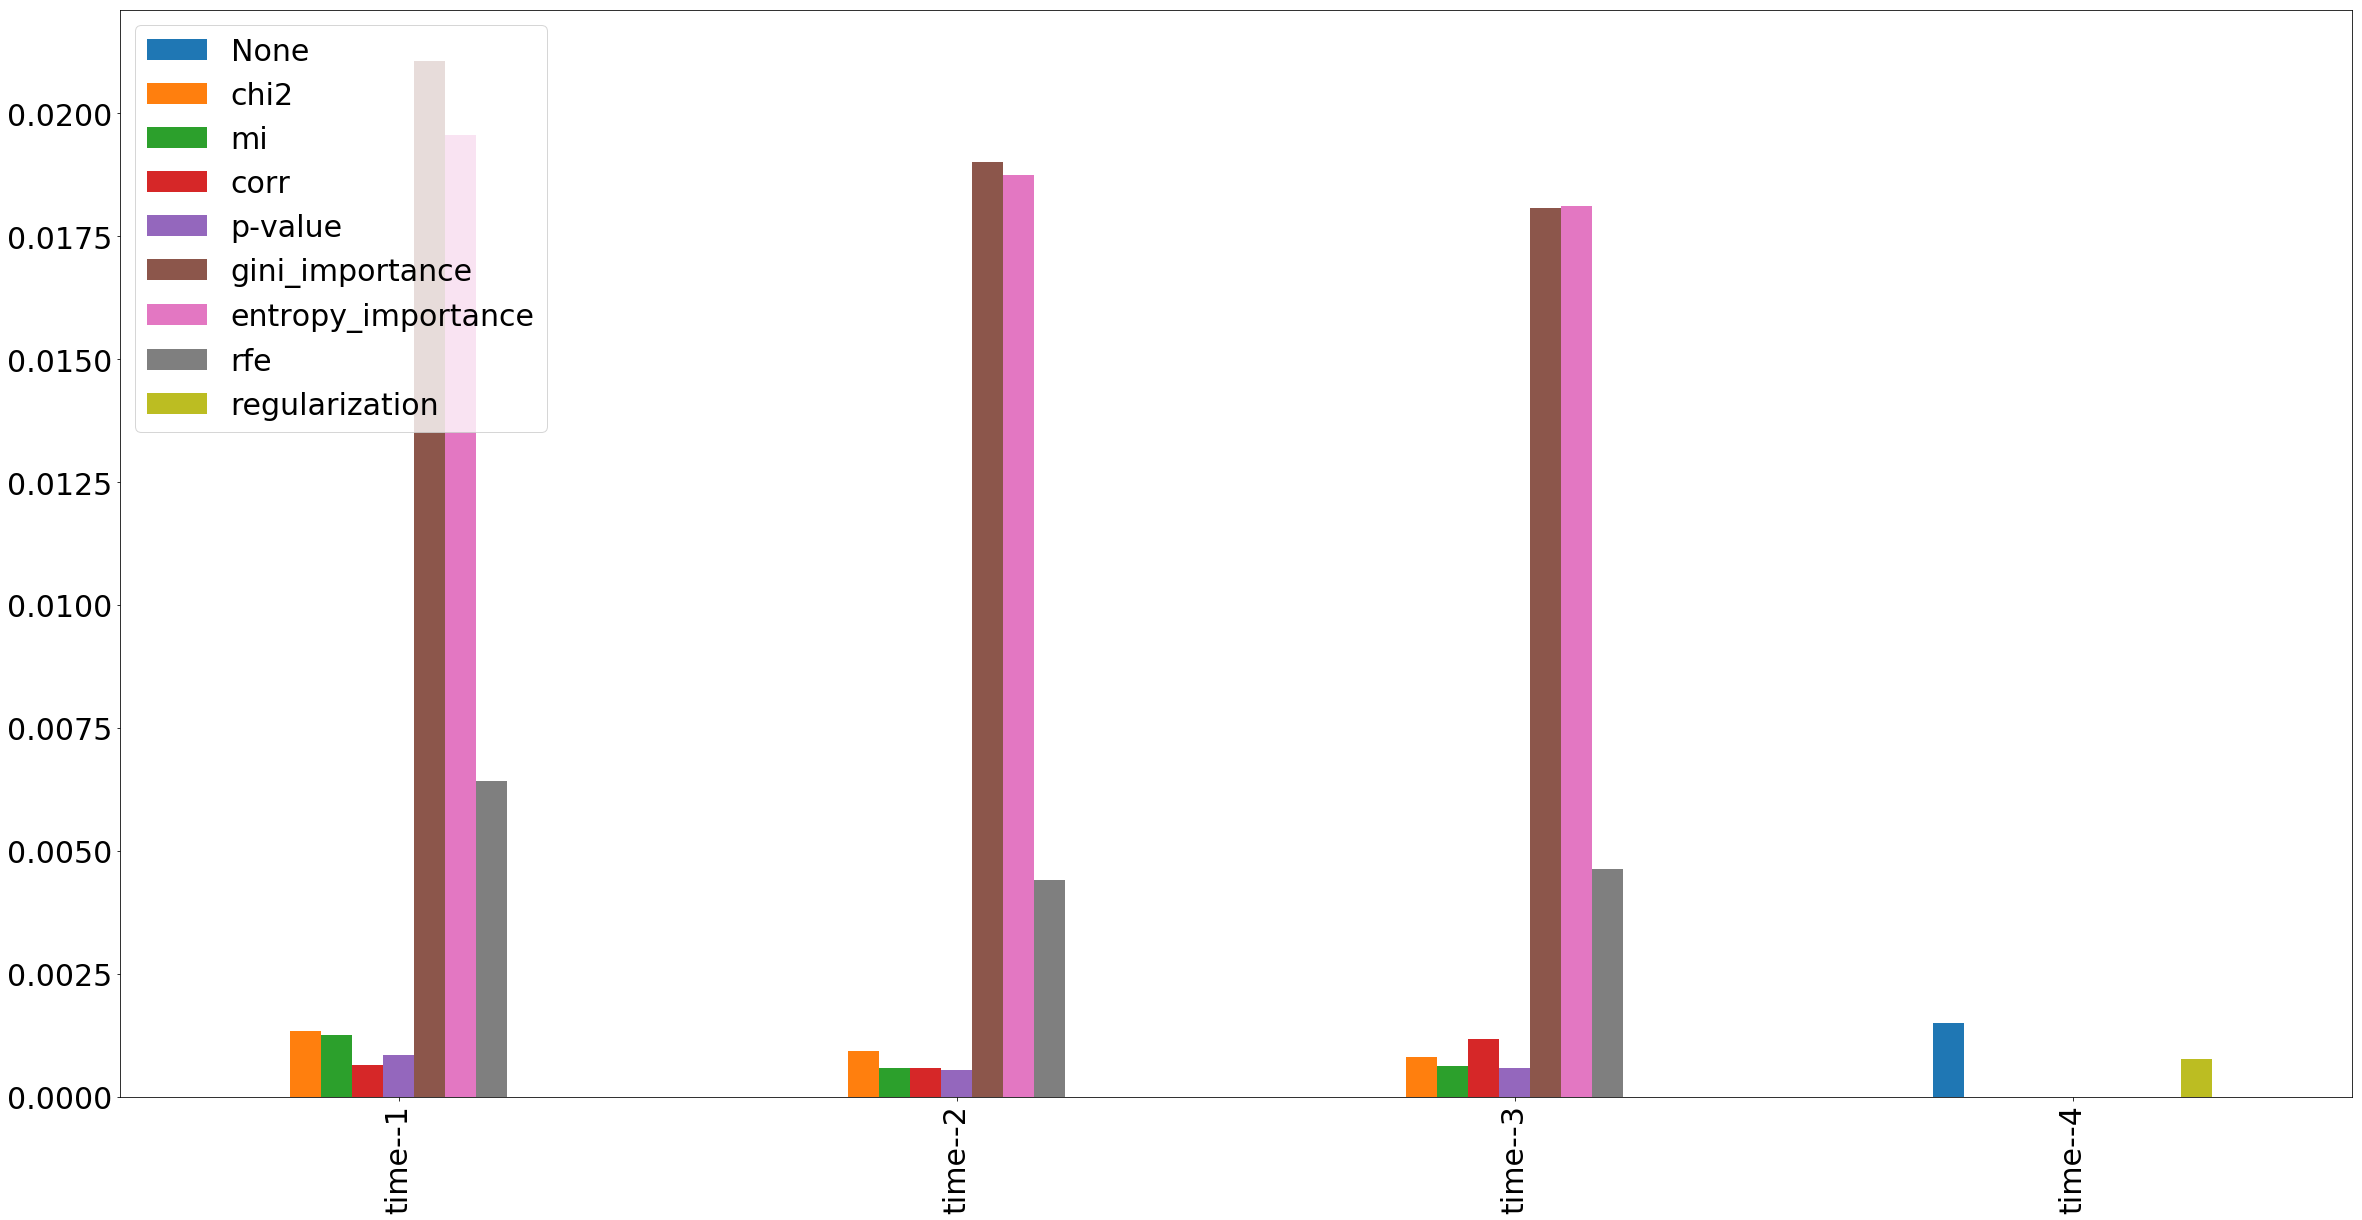

In [37]:

synthesis.T.plot(figsize=(40,20),kind ="bar",fontsize = 30).legend(loc=3, prop={'size': 30})
times.T.plot(figsize=(40,20),kind ="bar",fontsize = 30).legend(loc=2, prop={'size': 30})

Finally we got the results and we can easily see that with feature selection we get a very  acceptable accuracy in a very interesting time